# Preparing the Data

In [2]:
import glob

train_files = glob.glob('./data/cities_train/train/*.txt')
val_files = glob.glob('./data/cities_val/val/*.txt')

In [3]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_to_ascii('Ślusàrski'))

Slusarski


In [4]:
# Build the category_lines dictionary, a list of names per language
category_lines_train = {}
category_lines_val = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, "r", encoding='utf-8', errors='ignore').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

for filename in train_files:
    category = filename.split('/')[-1].split('.')[0]
    category = filename.split('\\')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines_train[category] = lines

for filename in val_files:
    category = filename.split('/')[-1].split('.')[0]
    category = filename.split('\\')[-1].split('.')[0]
    lines = readLines(filename)
    category_lines_val[category] = lines

n_categories = len(all_categories)
print('n_categories =', n_categories)

n_categories = 9


Now we have `category_lines`, a dictionary mapping each category (language) to a list of lines (names). We also kept track of `all_categories` (just a list of languages) and `n_categories` for later reference.

In [5]:
print(category_lines_train['af'][:5])
print(category_lines_val['af'][:5])

['garavshakh', 'kalishli', 'sarban kelay', 'dahane surunah', 'jahannum']
['sikhtopa', 'laferronay', 'cham ghafur', 'souk tafetecht', 'panqash']


# Turning Names into Tensors

Now that we have all the names organized, we need to turn them into Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size `<1 x n_letters>`. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. `"b" = <0 1 0 0 0 ...>`.

To make a word we join a bunch of those into a 2D matrix `<line_length x 1 x n_letters>`.

That extra 1 dimension is because PyTorch assumes everything is in batches - we're just using a batch size of 1 here.

In [6]:
import torch

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    letter_index = all_letters.find(letter)
    tensor[0][letter_index] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        letter_index = all_letters.find(letter)
        tensor[li][0][letter_index] = 1
    return tensor

In [7]:
print(letter_to_tensor('J'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


In [8]:
print(line_to_tensor('Jones').size())

torch.Size([5, 1, 57])


# Creating the Network

Before autograd, creating a recurrent neural network in Torch involved cloning the parameters of a layer over several timesteps. The layers held hidden state and gradients which are now entirely handled by the graph itself. This means you can implement a RNN in a very "pure" way, as regular feed-forward layers.

This RNN module (mostly copied from [the PyTorch for Torch users tutorial](https://github.com/pytorch/tutorials/blob/master/Introduction%20to%20PyTorch%20for%20former%20Torchies.ipynb)) is just 2 linear layers which operate on an input and hidden state, with a LogSoftmax layer after the output.

![](https://i.imgur.com/Z2xbySO.png)

In [9]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

## Manually testing the network

With our custom `RNN` class defined, we can create a new instance:

In [10]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). We'll get back the output (probability of each language) and a next hidden state (which we keep for the next step).

Remember that PyTorch modules operate on Variables rather than straight up Tensors.

In [11]:
input = Variable(letter_to_tensor('A'))
hidden = rnn.init_hidden()

output, next_hidden = rnn(input, hidden)
print('output.size =', output.size())

output.size = torch.Size([1, 9])


For the sake of efficiency we don't want to be creating a new Tensor for every step, so we will use `line_to_tensor` instead of `letter_to_tensor` and use slices. This could be further optimized by pre-computing batches of Tensors.

In [12]:
input = Variable(line_to_tensor('Albert'))
hidden = rnn.init_hidden()

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.2670, -2.1623, -2.2027, -2.2116, -2.2503, -2.1981, -2.1707, -2.1280,
         -2.1918]], grad_fn=<LogSoftmaxBackward>)


As you can see the output is a `<1 x n_categories>` Tensor, where every item is the likelihood of that category (higher is more likely).

# Preparing for Training

Before going into training we should make a few helper functions. The first is to interpret the output of the network, which we know to be a likelihood of each category. We can use `Tensor.topk` to get the index of the greatest value:

In [13]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

print(category_from_output(output))

('pk', tensor(7))


We will also want a quick way to get a training example (a name and its language):

In [14]:
import random

def random_training_pair():                                                                                                               
    category = random.choice(all_categories)
    line = random.choice(category_lines_train[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(line_to_tensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = random_training_pair()
    print('category =', category, '/ line =', line)

category = ir / line = valame bala
category = af / line = khaftawt
category = za / line = sakhibzadakheyl'
category = za / line = siriza
category = fi / line = iso evo
category = fi / line = riippi
category = fr / line = friolfe
category = in / line = chak ninetythree sb
category = af / line = mantigak
category = fi / line = kafir kala


In [15]:
def random_val_pair():                                                                                                               
    category = random.choice(all_categories)
    line = random.choice(category_lines_val[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(line_to_tensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = random_val_pair()
    print('category =', category, '/ line =', line)

category = fi / line = gbangbanfira
category = de / line = erzenbach
category = in / line = ma'murin
category = pk / line = khempura
category = af / line = shah vali
category = de / line = desrobitiiminastirea
category = cn / line = nantien
category = za / line = kwamjiji
category = cn / line = linangou
category = fi / line = vahasorvasto


# Training the Network

Now all it takes to train this network is show it a bunch of examples, have it make guesses, and tell it if it's wrong.

For the [loss function `nn.NLLLoss`](http://pytorch.org/docs/nn.html#nllloss) is appropriate, since the last layer of the RNN is `nn.LogSoftmax`.

We will also create an "optimizer" which updates the parameters of our model according to its gradients. We will use the vanilla SGD algorithm with a low learning rate.

In [16]:
criterion = nn.NLLLoss()

learning_rate = 0.001 # If you set this too high, it might explode. If too low, it might not learn
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

Each loop of training will:

* Create input and target tensors
* Create a zeroed initial hidden state
* Read each letter in and
    * Keep hidden state for next letter
* Compare final output to target
* Back-propagate
* Return the output and loss

In [17]:
def train(category_tensor, line_tensor):
    rnn.zero_grad()
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    optimizer.step()

    return output, loss.data

def validation(category_tensor, line_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)

    return loss.data

Now we just have to run that with a bunch of examples. Since the `train` function returns both the output and loss we can print its guesses and also keep track of loss for plotting. Since there are 1000s of examples we print only every `print_every` time steps, and take an average of the loss.

In [18]:
import time
import math

n_epochs = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss_train = 0
current_loss_val = 0
all_losses_train = []
all_losses_val = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

In [17]:
for epoch in range(1, n_epochs + 1):
    # Get a random training input and target
    category, line, category_tensor, line_tensor = random_training_pair()
    output, loss = train(category_tensor, line_tensor)
    current_loss_train += loss
    
    category, line, category_tensor, line_tensor = random_val_pair()
    loss = validation(category_tensor, line_tensor)
    current_loss_val += loss
    
    # Print epoch number, loss, name and guess
    if epoch % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / n_epochs * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if epoch % plot_every == 0:
        all_losses_train.append(current_loss_train / plot_every)
        all_losses_val.append(current_loss_val / plot_every)
        current_loss_train = 0
        current_loss_val = 0

5000 5% (0m 23s) 2.2049 bazanwara / fr ✗ (za)
10000 10% (0m 44s) 2.2018 leiqiao / in ✗ (cn)
15000 15% (1m 4s) 2.2150 safiye / fr ✗ (fi)
20000 20% (1m 24s) 2.1923 asagimicingirt / pk ✗ (ir)
25000 25% (1m 44s) 2.2052 finca semococh / cn ✗ (fi)
30000 30% (2m 9s) 1.8399 bassfield / cn ✗ (fi)
35000 35% (2m 33s) 2.5879 finsterbergen / pk ✗ (fi)
40000 40% (2m 56s) 0.6663 qingquyao / cn ✓
45000 45% (3m 17s) 1.6813 lutcza / in ✗ (za)
50000 50% (3m 38s) 0.8376 wedderburn junction / pk ✗ (de)
55000 55% (3m 59s) 3.6717 vrywillig / fi ✗ (za)
60000 60% (4m 21s) 1.6224 bonabdan / fr ✗ (ir)
65000 65% (4m 39s) 1.6667 karrapu / de ✗ (ir)
70000 70% (5m 0s) 1.4444 koke di basti / fr ✗ (pk)
75000 75% (5m 19s) 1.1309 villardecas / fi ✗ (de)
80000 80% (5m 40s) 2.6829 le gleffien / fi ✓
85000 85% (6m 3s) 0.7010 el paraiso de las flores / af ✗ (de)
90000 90% (6m 24s) 0.3434 tuleza / pk ✗ (za)
95000 95% (6m 47s) 2.9109 satin / de ✗ (pk)
100000 100% (7m 8s) 1.6837 palsa / za ✗ (fi)


# Plotting the Results

Plotting the historical loss from `all_losses` shows the network learning:

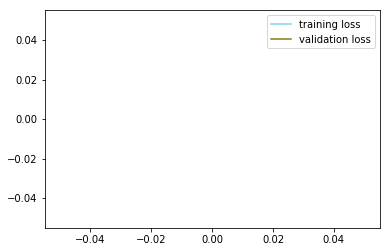

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses_train, color='skyblue', label='training loss')
plt.plot(all_losses_val, color='olive', label='validation loss')
plt.legend()

# Evaluating the Results

To see how well the network performs on different categories, we will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). To calculate the confusion matrix a bunch of samples are run through the network with `evaluate()`, which is the same as `train()` minus the backprop.

In [20]:
def compute_acc(matrix):
    micro_acc = torch.sum(matrix.diag()) / torch.sum(matrix)
    macro_acc = TP_pos = 0
    for row in matrix:
        macro_acc += (row[TP_pos] / row.sum())
        TP_pos += 1
    
    macro_acc /= len(matrix)
    return round(float(micro_acc), 8), round(float(macro_acc), 8)

micro_acc: 0.1105 macro_acc: 0.11063835


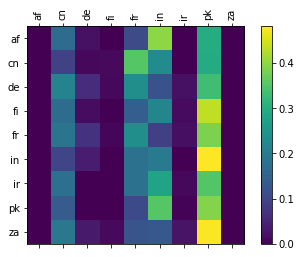

In [21]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_val_pair()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

micro_acc, macro_acc = compute_acc(confusion)
print('micro_acc:', micro_acc, 'macro_acc:', macro_acc)

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

# Different RNN Configurations

In [22]:
def RNN_config(n_hidden=128):
    rnn = RNN(n_letters, n_hidden, n_categories)
    
    return rnn

# Keep track of losses for plotting
def train_config(n_epochs=100000):
    print_every = 5000
    plot_every = 1000
    current_loss_train = 0
    current_loss_val = 0
    all_losses_train = []
    all_losses_val = []
    for epoch in range(1, n_epochs + 1):
        # Get a random training input and target
        category, line, category_tensor, line_tensor = random_training_pair()
        output, loss = train(category_tensor, line_tensor)
        current_loss_train += loss

        category, line, category_tensor, line_tensor = random_val_pair()
        loss = validation(category_tensor, line_tensor)
        current_loss_val += loss

        # Print epoch number, loss, name and guess
        if epoch % print_every == 0:
            guess, guess_i = category_from_output(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / n_epochs * 100, time_since(start), loss, line, guess, correct))

        # Add current loss avg to list of losses
        if epoch % plot_every == 0:
            all_losses_train.append(current_loss_train / plot_every)
            all_losses_val.append(current_loss_val / plot_every)
            current_loss_train = 0
            current_loss_val = 0
    
    return all_losses_train, all_losses_val

def show_loss(all_losses_train, current_loss_val):
    plt.figure()
    plt.plot(all_losses_train, color='skyblue', label='training loss')
    plt.plot(all_losses_val, color='olive', label='validation loss')
    plt.legend()

def acc_score():
    confusion = torch.zeros(n_categories, n_categories)
    n_confusion = 10000

    # Just return an output given a line
    def evaluate(line_tensor):
        hidden = rnn.init_hidden()

        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)

        return output

    # Go through a bunch of examples and record which are correctly guessed
    for i in range(n_confusion):
        category, line, category_tensor, line_tensor = random_val_pair()
        output = evaluate(line_tensor)
        guess, guess_i = category_from_output(output)
        category_i = all_categories.index(category)
        confusion[category_i][guess_i] += 1
    
    micro_acc, macro_acc = compute_acc(confusion)
    print('micro_acc:', micro_acc, 'macro_acc:', macro_acc)
    
    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.numpy())
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + all_categories, rotation=90)
    ax.set_yticklabels([''] + all_categories)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

## learning_rate=0.0001

n_hidden=128
all_losses_train, current_loss_val
5000 5% (7m 39s) 2.1413 mamfenweni / za ✓
10000 10% (7m 59s) 2.1056 ntywanka / fr ✗ (za)
15000 15% (8m 19s) 2.1190 tuleza / ir ✗ (za)
20000 20% (8m 39s) 2.2096 leppina / fi ✗ (in)
25000 25% (8m 58s) 2.2034 friedrichswerth / fi ✗ (fr)
30000 30% (9m 18s) 2.1756 zhangpocun / pk ✗ (cn)
35000 35% (9m 37s) 2.1189 rexpoede / cn ✗ (fr)
40000 40% (9m 57s) 2.1922 virrat / fr ✗ (fi)
45000 45% (10m 17s) 2.1996 dazhangjingqiao / fi ✗ (in)
50000 50% (10m 36s) 2.1086 rexpoede / fi ✗ (fr)
55000 55% (10m 57s) 2.2477 shuangfo / pk ✗ (cn)
60000 60% (11m 18s) 2.0891 tsaochiatsun / cn ✓
65000 65% (11m 39s) 2.2040 shuipo / fr ✗ (cn)
70000 70% (11m 59s) 2.1831 lissenthan / fr ✗ (de)
75000 75% (12m 20s) 2.2060 wedderburn junction / fr ✗ (de)
80000 80% (12m 40s) 2.3104 kafr al arbain / fr ✗ (af)
85000 85% (13m 0s) 2.1375 phahla / fr ✗ (za)
90000 90% (13m 19s) 2.1879 dehe biram / fr ✗ (ir)
95000 95% (13m 39s) 2.1907 zagotstok / cn ✗ (za)
100000 100% (13m 59s) 2.20

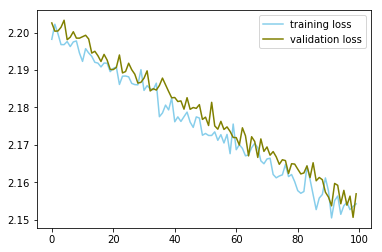

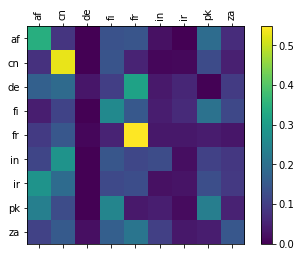

In [22]:
print('n_hidden=128')
rnn = RNN_config(n_hidden=128)

criterion = nn.NLLLoss()
optimizer=torch.optim.SGD(rnn.parameters(), lr=0.0001)

print('all_losses_train, current_loss_val')
all_losses_train, all_losses_val = train_config(n_epochs=100000)
show_loss(all_losses_train, all_losses_val)

print('acc_score')
acc_score()

## learning_rate=0.001

n_hidden=128
all_losses_train, current_loss_val
5000 5% (14m 31s) 2.0843 lentuankoski / ir ✗ (fi)
10000 10% (14m 51s) 1.9060 faverelles / fr ✓
15000 15% (15m 11s) 1.9587 khostay / de ✗ (af)
20000 20% (15m 31s) 1.9108 niuhala / fr ✗ (fi)
25000 25% (15m 52s) 1.6721 sorede / cn ✗ (fr)
30000 30% (16m 14s) 2.0920 awlade mirza / in ✗ (af)
35000 35% (16m 34s) 3.0721 spina / fi ✗ (af)
40000 40% (16m 55s) 1.7746 muefi / cn ✗ (fi)
45000 45% (17m 15s) 1.3521 bazanwara / fi ✗ (za)
50000 50% (17m 36s) 0.8447 kinong dzong / cn ✓
55000 55% (17m 56s) 1.3339 shenwuchen / ir ✗ (cn)
60000 60% (18m 17s) 0.3468 cazenaveserreetallens / za ✗ (fr)
65000 65% (18m 37s) 0.8301 dahane akhtah khanah / za ✗ (af)
70000 70% (19m 1s) 1.1194 basti mad ubha / af ✗ (pk)
75000 75% (19m 24s) 2.3536 nerchinskzavod / ir ✗ (za)
80000 80% (19m 46s) 1.8971 sedgefield / fr ✗ (fi)
85000 85% (20m 6s) 1.3008 korlolagh karez / ir ✗ (af)
90000 90% (20m 27s) 0.4850 basti gahna khan / in ✗ (pk)
95000 95% (20m 48s) 2.6160 ditodai dano /

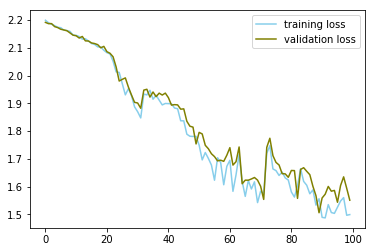

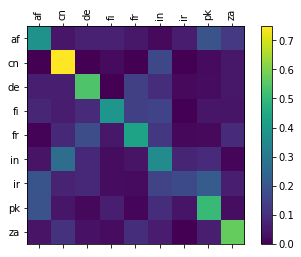

In [23]:
print('n_hidden=128')
rnn = RNN_config(n_hidden=128)

criterion = nn.NLLLoss()
optimizer=torch.optim.SGD(rnn.parameters(), lr=0.001)

print('all_losses_train, current_loss_val')
all_losses_train, all_losses_val = train_config(n_epochs=100000)
show_loss(all_losses_train, all_losses_val)

print('acc_score')
acc_score()

## learning_rate=0.0015

n_hidden=128
all_losses_train, current_loss_val
5000 3% (86m 11s) 2.2271 jaurdi / in ✗ (ir)
10000 6% (86m 32s) 1.9361 tungloutsun / de ✗ (cn)
15000 10% (86m 58s) 2.0500 buzanovo / fi ✗ (za)
20000 13% (87m 24s) 1.3864 barab chah / cn ✗ (pk)
25000 16% (87m 45s) 1.9633 kothi sewa ram / fi ✗ (pk)
30000 20% (88m 6s) 2.7789 hatfield peverel / af ✗ (fi)
35000 23% (88m 27s) 1.6399 kumtala / za ✓
40000 26% (88m 49s) 2.4390 slapkina / ir ✗ (pk)
45000 30% (89m 11s) 0.9992 shuangfo / in ✗ (cn)
50000 33% (89m 32s) 1.4972 ma'murin / cn ✗ (in)
55000 36% (89m 54s) 1.3083 luzancon / za ✓
60000 40% (90m 13s) 1.0479 armordah / fi ✗ (ir)
65000 43% (90m 35s) 2.0650 le castang / cn ✗ (fr)
70000 46% (90m 56s) 1.7187 ma'murin / af ✗ (in)
75000 50% (91m 18s) 0.9624 nantien / cn ✓
80000 53% (91m 39s) 0.5600 fengjiazhaiji / fr ✗ (cn)
85000 56% (92m 1s) 3.4632 ganda cheshmeh / za ✗ (af)
90000 60% (92m 21s) 0.7796 novoyedelevo / in ✗ (de)
95000 63% (92m 42s) 0.2347 jinpanxing / fr ✗ (in)
100000 66% (93m 2s) 1.9199

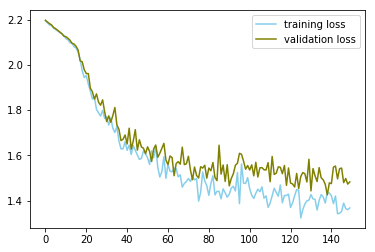

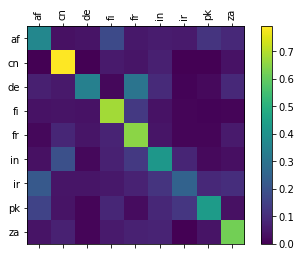

In [52]:
print('n_hidden=128')
rnn = RNN_config(n_hidden=128)

criterion=nn.NLLLoss()
optimizer=torch.optim.SGD(rnn.parameters(), lr=0.0015)
print('all_losses_train, current_loss_val')
all_losses_train, all_losses_val = train_config(n_epochs=150000)
show_loss(all_losses_train, all_losses_val)

print('acc_score')
acc_score()

## learning_rate=0.002

n_hidden=128
all_losses_train, current_loss_val
5000 5% (74m 54s) 2.1464 ballingeary / za ✗ (in)
10000 10% (75m 17s) 1.9462 harvanmaki / fi ✓
15000 15% (75m 39s) 2.2613 kirchovon / cn ✗ (ir)
20000 20% (76m 0s) 1.8665 lakthi / fr ✗ (pk)
25000 25% (76m 23s) 1.8062 garamotlokana / pk ✗ (za)
30000 30% (76m 46s) 1.0798 magdebacken / ir ✗ (de)
35000 35% (77m 10s) 3.2702 sardinia bay / af ✗ (za)
40000 40% (77m 32s) 0.6400 al muzayrib / fr ✗ (za)
45000 45% (77m 54s) 1.8633 sache / fi ✗ (fr)
50000 50% (78m 16s) 4.0713 dzholozi / pk ✗ (af)
55000 55% (78m 38s) 2.6174 kumtala / pk ✗ (za)
60000 60% (79m 0s) 1.0818 bharsaf / za ✗ (af)
65000 65% (79m 21s) 1.4086 burughsanak / cn ✗ (af)
70000 70% (79m 43s) 3.4587 nordenlund / fr ✗ (fi)
75000 75% (80m 4s) 0.6198 auterrive / ir ✗ (fr)
80000 80% (80m 25s) 2.0251 bjurs / fi ✓
85000 85% (80m 48s) 1.2459 fridenrekht / de ✗ (fr)
90000 90% (81m 8s) 0.2520 ghwareza / de ✗ (za)
95000 95% (81m 28s) 1.2171 las virginias / fr ✗ (in)
100000 100% (81m 48s) 1.3892 qa

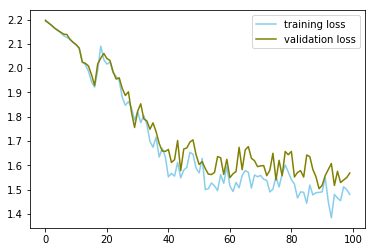

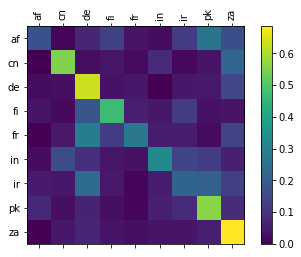

In [40]:
print('n_hidden=128')
rnn = RNN_config(n_hidden=128)

criterion=nn.NLLLoss()
optimizer=torch.optim.SGD(rnn.parameters(), lr=0.002)
print('all_losses_train, current_loss_val')
all_losses_train, all_losses_val = train_config(n_epochs=100000)
show_loss(all_losses_train, all_losses_val)

print('acc_score')
acc_score()

## learning_rate=0.003

n_hidden=128
all_losses_train, current_loss_val
5000 5% (82m 21s) 2.1175 l'houmeau / fi ✗ (fr)
10000 10% (82m 41s) 1.6516 padenganploso / fr ✗ (de)
15000 15% (83m 1s) 2.4080 mina aguilar / fr ✗ (in)
20000 20% (83m 20s) 1.7296 mehr sabz / in ✗ (ir)
25000 25% (83m 41s) 2.0982 cham ghafur / za ✗ (af)
30000 30% (84m 1s) 1.7513 harvanmaki / in ✗ (fi)
35000 35% (84m 20s) 0.2477 azamazu / fr ✗ (za)
40000 40% (84m 40s) 2.1547 padenganploso / ir ✗ (de)
45000 45% (85m 0s) 2.5590 obermairhof / za ✗ (ir)
50000 50% (85m 20s) 0.1891 xueguangzhang / za ✗ (cn)
55000 55% (85m 40s) 1.1163 arou lahoucine / za ✗ (in)
60000 60% (86m 1s) 1.5086 qala viala / za ✗ (pk)
65000 65% (86m 21s) 1.9183 leyr / pk ✗ (fr)
70000 70% (86m 42s) 0.7564 jinda kiman / cn ✗ (pk)
75000 75% (87m 1s) 2.2382 godho zardari / de ✗ (pk)
80000 80% (87m 22s) 0.8322 karpinvaara / ir ✗ (fi)
85000 85% (87m 42s) 1.0463 ngxazana / fr ✗ (za)
90000 90% (88m 2s) 3.1663 plaza de gogenuri / af ✗ (za)
95000 95% (88m 23s) 1.9528 shaochialou / pk 

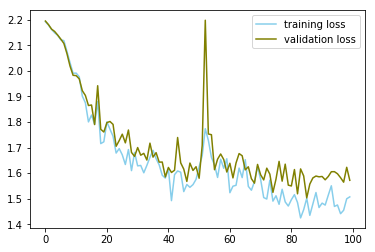

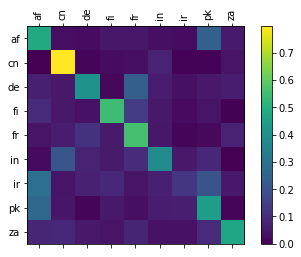

In [41]:
print('n_hidden=128')
rnn = RNN_config(n_hidden=128)

criterion=nn.NLLLoss()
optimizer=torch.optim.SGD(rnn.parameters(), lr=0.003)
print('all_losses_train, current_loss_val')
all_losses_train, all_losses_val = train_config(n_epochs=100000)
show_loss(all_losses_train, all_losses_val)

print('acc_score')
acc_score()

## hidden layer size = 256

n_hidden=256
all_losses_train, current_loss_val
5000 5% (89m 28s) 2.0742 vahasorvasto / in ✗ (fi)
10000 10% (89m 59s) 2.2067 sitio alberto pereira / fi ✗ (ir)
15000 15% (90m 29s) 2.2785 kafr barshum al kubra / af ✗ (fr)
20000 20% (90m 59s) 2.0411 galeh kahriz / pk ✗ (ir)
25000 25% (91m 29s) 2.0638 hitzacker / za ✓
30000 30% (91m 58s) 3.0292 montgomery / pk ✓
35000 35% (92m 31s) 1.6916 jiuquan shi / af ✗ (cn)
40000 40% (93m 4s) 2.8594 shiramotohasunumacho / fi ✗ (ir)
45000 45% (93m 36s) 2.1230 shinglanah / af ✓
50000 50% (94m 8s) 2.5732 lombo de figueira / cn ✗ (ir)
55000 55% (94m 39s) 0.8802 grandecourt / de ✗ (fr)
60000 60% (95m 9s) 2.0489 ismail / pk ✓
65000 65% (95m 39s) 1.5041 xixin / in ✗ (cn)
70000 70% (96m 9s) 0.1657 zarnao mela / fr ✗ (za)
75000 75% (96m 39s) 1.1973 armordah / cn ✗ (ir)
80000 80% (97m 11s) 1.1923 rexpoede / cn ✗ (fr)
85000 85% (97m 40s) 0.5274 shexingzui / af ✗ (cn)
90000 90% (98m 10s) 0.8124 quijinga / cn ✗ (in)
95000 95% (98m 40s) 1.7128 schonhardt / de ✓
100

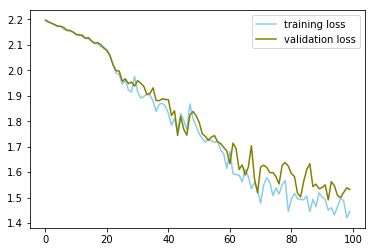

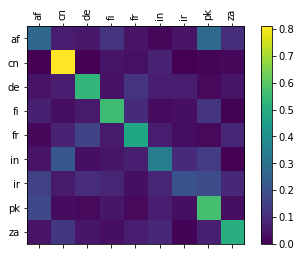

In [42]:
print('n_hidden=256')
rnn = RNN_config(n_hidden=256)

criterion=nn.NLLLoss()
optimizer=torch.optim.SGD(rnn.parameters(), lr=0.001)
print('all_losses_train, current_loss_val')
all_losses_train, all_losses_val = train_config(n_epochs=100000)
show_loss(all_losses_train, all_losses_val)

print('acc_score')
acc_score()

## hidden layer size = 512

n_hidden=512
all_losses_train, current_loss_val
5000 3% (29m 50s) 2.1171 marques de abrantes / fi ✗ (de)
10000 6% (31m 2s) 2.2762 mal asoli / cn ✗ (in)
15000 10% (32m 15s) 2.1317 muntele fillii / cn ✗ (fi)
20000 13% (33m 28s) 2.1062 huolangzhangzi / af ✗ (cn)
25000 16% (34m 40s) 2.2147 zaouia sidi bouzid / fi ✗ (za)
30000 20% (35m 59s) 1.5961 dhagal / cn ✗ (pk)
35000 23% (37m 18s) 1.6127 pasishakhimardan / de ✗ (af)
40000 26% (38m 32s) 1.1546 khara shang / pk ✓
45000 30% (39m 41s) 1.4028 myza purila / de ✗ (za)
50000 33% (40m 50s) 1.9349 joye shahi / ir ✗ (af)
55000 36% (42m 0s) 1.2773 shahrake khezer kenar / cn ✗ (ir)
60000 40% (43m 9s) 1.1631 mapingtai / ir ✗ (cn)
65000 43% (44m 19s) 1.9842 soppeenmaki / cn ✗ (fi)
70000 46% (45m 28s) 0.2976 azad mehr / za ✓
75000 50% (46m 37s) 1.0103 sanhe xiang / fi ✗ (cn)
80000 53% (48m 29s) 3.4800 garamotlokana / de ✗ (za)
85000 56% (63m 18s) 0.1190 verdelpino de huete / pk ✗ (de)
90000 60% (64m 43s) 0.8953 les arques / in ✗ (fr)
95000 63% (66m 27

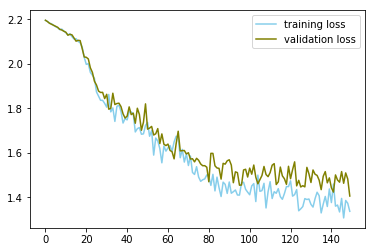

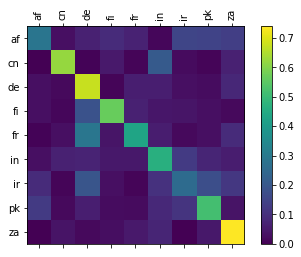

In [51]:
print('n_hidden=512')
rnn = RNN_config(n_hidden=512)

criterion=nn.NLLLoss()
optimizer=torch.optim.SGD(rnn.parameters(), lr=0.001)
print('all_losses_train, current_loss_val')
all_losses_train, all_losses_val = train_config(n_epochs=150000)
show_loss(all_losses_train, all_losses_val)

print('acc_score')
acc_score()

## optimizer = RMSprop

n_hidden=128
all_losses_train, current_loss_val
5000 5% (0m 33s) 1.1462 dhala / in ✗ (pk)
10000 10% (0m 54s) 1.0386 qowle bayan / fi ✗ (af)
15000 15% (1m 16s) 0.0110 niujiaoxu / cn ✓
20000 20% (1m 38s) 0.8281 unterhafing / ir ✗ (in)
25000 25% (2m 2s) 0.4898 tongyuanli / fr ✗ (cn)
30000 30% (2m 26s) 4.7357 vrywillig / cn ✗ (za)
35000 35% (2m 48s) 0.0866 kazarinovka / de ✗ (za)
40000 40% (3m 10s) 4.3855 phahla / cn ✗ (za)
45000 45% (3m 34s) 2.7340 lissenthan / cn ✗ (de)
50000 50% (3m 56s) 1.1550 karunga / fi ✗ (pk)
55000 55% (4m 19s) 2.2722 christinental / za ✗ (de)
60000 60% (4m 43s) 0.4138 kauppilanmaki / za ✗ (fi)
65000 65% (5m 4s) 0.0633 sankeyushu / cn ✓
70000 70% (5m 26s) 0.1233 esnouveaux / af ✗ (fr)
75000 75% (5m 48s) 0.9425 ali shams od din / cn ✗ (ir)
80000 80% (6m 10s) 0.5019 aniamarina / cn ✗ (in)
85000 85% (6m 32s) 0.4119 tavakulak / fr ✗ (af)
90000 90% (6m 53s) 0.6274 jiuquan shi / cn ✓
95000 95% (7m 15s) 1.0497 ban ka ching / cn ✗ (in)
100000 100% (7m 37s) 2.6339 birizag /

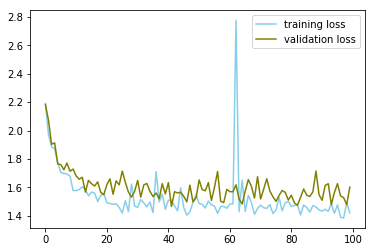

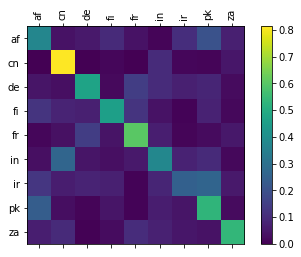

In [23]:
print('n_hidden=128')
rnn = RNN_config(n_hidden=128)

criterion=nn.NLLLoss()
optimizer=torch.optim.RMSprop(rnn.parameters(), lr=0.001)
print('all_losses_train, current_loss_val')
all_losses_train, all_losses_val = train_config(n_epochs=100000)
show_loss(all_losses_train, all_losses_val)

print('acc_score')
acc_score()

## optimizer = Adam

n_hidden=128
all_losses_train, current_loss_val
5000 5% (13m 20s) 2.4098 zarrik / cn ✗ (za)
10000 10% (13m 46s) 2.7192 sifu / pk ✗ (cn)
15000 15% (14m 9s) 1.0090 beguios / cn ✗ (fr)
20000 20% (14m 32s) 2.5674 sardinia bay / af ✗ (za)
25000 25% (14m 55s) 0.5114 khozahar / fi ✗ (za)
30000 30% (15m 17s) 1.9332 odemis / fr ✗ (de)
35000 35% (15m 39s) 0.4091 dash fishal / in ✗ (fi)
40000 40% (16m 2s) 33.1517 counenguiou / cn ✗ (fr)
45000 45% (16m 26s) 3487633.7500 qalehye haji karam / in ✗ (af)
50000 50% (16m 56s) 2033.5571 mamfenweni / fi ✗ (za)
55000 55% (17m 19s) 0.0000 sankt georgen am fillmannsbach / af ✗ (fi)
60000 60% (17m 42s) 1846.2333 ittefaqabad / ir ✗ (pk)
65000 65% (18m 5s) 0.0000 bayangaole / af ✗ (cn)
70000 70% (18m 28s) 2113.7378 sultani kili / de ✗ (pk)
75000 75% (18m 51s) 0.0000 shapingtang / fi ✗ (in)
80000 80% (19m 14s) 3.0082 leyr / pk ✗ (fr)
85000 85% (19m 39s) 468090432.0000 pilipovskiye korichintsy / za ✗ (in)
90000 90% (20m 3s) 38701020.0000 dahane akhtah khanah / fi

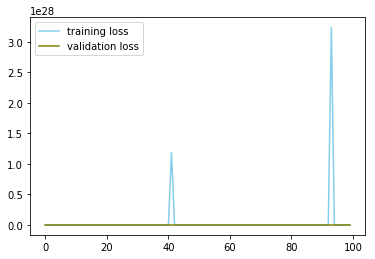

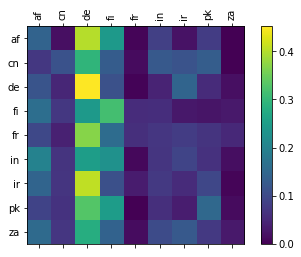

In [49]:
print('n_hidden=128')
rnn = RNN_config(n_hidden=128)

criterion=nn.NLLLoss()
optimizer=torch.optim.Adam(rnn.parameters(), lr=0.001)
print('all_losses_train, current_loss_val')
all_losses_train, all_losses_val = train_config(n_epochs=100000)
show_loss(all_losses_train, all_losses_val)

print('acc_score')
acc_score()

## optimizer = ASGD

n_hidden=128
all_losses_train, current_loss_val
5000 5% (21m 20s) 2.1099 cabezavellosa de la calzada / za ✓
10000 10% (21m 41s) 2.0005 hasseling / pk ✗ (in)
15000 15% (22m 3s) 2.1151 goth hussain laghari / af ✗ (pk)
20000 20% (22m 24s) 2.2657 ballingeary / af ✗ (in)
25000 25% (22m 45s) 1.9934 sache / za ✗ (fr)
30000 30% (23m 7s) 2.7864 la fauga / cn ✗ (fr)
35000 35% (23m 29s) 2.3687 sao francisco da a legua / pk ✗ (fr)
40000 40% (23m 51s) 1.3690 medina quemade / cn ✗ (de)
45000 45% (24m 14s) 1.3005 naodian / in ✗ (cn)
50000 50% (24m 34s) 1.6226 robate aghaj / de ✗ (ir)
55000 55% (24m 55s) 1.9419 punye / za ✗ (cn)
60000 60% (25m 17s) 0.8252 qingguji / za ✗ (cn)
65000 65% (25m 40s) 0.8332 ali shams od din / af ✗ (ir)
70000 70% (26m 6s) 1.2965 samengtzu / fr ✗ (cn)
75000 75% (26m 30s) 1.0033 toyorden / af ✗ (de)
80000 80% (26m 53s) 1.7087 khairo buriro / ir ✗ (pk)
85000 85% (27m 15s) 1.3101 solok gematir / in ✗ (ir)
90000 90% (27m 36s) 1.1470 la giraudiere / af ✗ (fr)
95000 95% (27m 58s) 

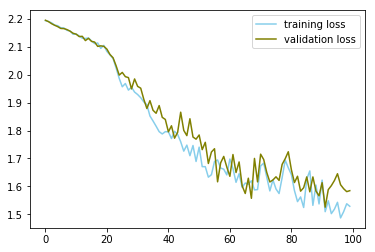

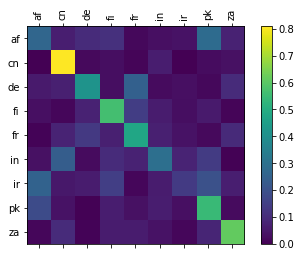

In [50]:
print('n_hidden=128')
rnn = RNN_config(n_hidden=128)

criterion=nn.NLLLoss()
optimizer=torch.optim.ASGD(rnn.parameters(), lr=0.001)
print('all_losses_train, current_loss_val')
all_losses_train, all_losses_val = train_config(n_epochs=100000)
show_loss(all_losses_train, all_losses_val)

print('acc_score')
acc_score()